In [157]:
import torch
from pp_query.models import SelfCorrectingModel
from pp_query.censor import CensoredPP, CensoredTimeline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, PercentFormatter
import matplotlib 
matplotlib.rc('font', family='serif')
matplotlib.rc('text', usetex=True)

In [20]:
m = SelfCorrectingModel(1, False, 1.0)
m.alphas.weight.data = 0*m.alphas.weight.data + 0.5
m.mus.data = 0*m.mus.data + 0.5

In [29]:
T = 10.0
torch.manual_seed(2)
with torch.no_grad():
    times, marks, states = m.batch_sample_points(None, None, None, T)
    times, marks, states = times[0], marks[0], states[0]

    x = torch.linspace(0, T, 10000)
    print("Original")
    orig_intensity = m.get_intensity(states, times, x.unsqueeze(0))

    censoring = CensoredTimeline(
        (3., 7.),
        [0],
        1,
    )
    cm = CensoredPP(
        m,
        censoring,
        100,
        True,
    )
    c_times, c_marks = censoring.filter_sequences(times, marks)

    print("Naive")
    naive_intensity = m.get_intensity(None, c_times, x.unsqueeze(0), None, c_marks)
    print("Baseline")
    baseline_intensity = m.get_intensity(None, c_times, x.unsqueeze(0), None, c_marks, censoring=censoring)
    print("Censored")
    censored_intensity = cm.intensity(c_times.squeeze(), c_marks.squeeze(), x)

Original
Naive
Baseline
Censored


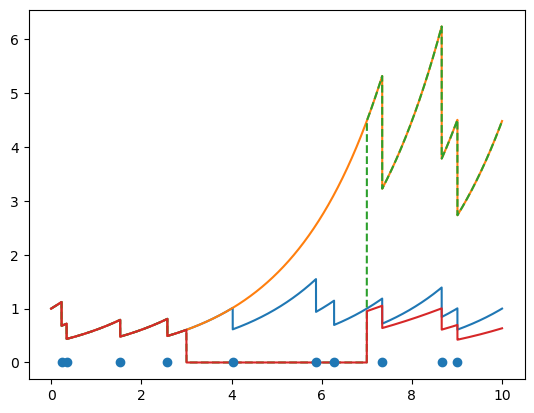

In [35]:
colors = ["tab:blue", "tab:orange", "tab:green", "tab:red"]
names = ["Original", "Naive", "Baseline", "Censored"]
intensities = [orig_intensity, naive_intensity, baseline_intensity, censored_intensity]
for color, name, intensity in zip(colors, names, intensities):
    if name == "Censored":
        plt.plot(x, intensity["intensity"].sum(dim=-1).squeeze(), '-', label=name, color=color)
    else:
        plt.plot(x, intensity["observed_int" if name=="Baseline" else "total_intensity"].squeeze(), "--" if name=="Baseline" else '-', label=name, color=color)
plt.plot(times.squeeze(), times.squeeze()*0.0, 'o', color=colors[0])

In [84]:
m = SelfCorrectingModel(2, False, 1.0)
m.alphas.weight.data[0, 0] = 0*m.alphas.weight.data[0, 0] + 0.25
m.alphas.weight.data[0, 1] = 0*m.alphas.weight.data[0, 1] + 0.25
m.alphas.weight.data[1, 0] = 0*m.alphas.weight.data[1, 0] + 0.0
m.alphas.weight.data[1, 1] = 0*m.alphas.weight.data[1, 1] + 0.25
m.mus.data[0] = 0*m.mus.data[0] + 0.2
m.mus.data[1] = 0*m.mus.data[1] + 0.2

T = 15.0
torch.manual_seed(4)
with torch.no_grad():
    times, marks, states = m.batch_sample_points(None, None, None, T)
    times, marks, states = times[0], marks[0], states[0]

    print(times, marks)

    x = torch.linspace(0, T, 10000)
    print("Original")
    orig_intensity = m.get_intensity(states, times, x.unsqueeze(0))

    censoring = CensoredTimeline(
        (3., 7.),
        [0],
        2,
    )
    cm = CensoredPP(
        m,
        censoring,
        100,
        True,
    )
    c_times, c_marks = censoring.filter_sequences(times, marks)

    print("Naive")
    naive_intensity = m.get_intensity(None, c_times, x.unsqueeze(0), None, c_marks)
    print("Baseline")
    baseline_intensity = m.get_intensity(None, c_times, x.unsqueeze(0), None, c_marks, censoring=censoring)
    print("Censored")
    censored_intensity = cm.intensity(c_times.squeeze(), c_marks.squeeze(), x)

tensor([[ 0.3163,  1.2360,  1.7078,  2.4811,  2.5635,  2.8857,  4.6289,  5.6025,
          5.6123,  5.7284,  5.8131,  6.3738,  7.1087, 11.0173, 11.3249, 12.1162,
         12.1746, 12.1959]]) tensor([[0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0]])
Original
Naive
Baseline
Censored


In [134]:
new_times, new_marks = [], []
for st, sm in zip(censored_intensity["sampled_times"], censored_intensity["sampled_marks"]):
    nt, nm = st[:, c_times.numel():], sm[:, c_times.numel():]
    nt, nm = nt[(nt >= 3.) & (nt <= 7.)], nm[(nt >= 3.) & (nt <= 7.)]
    new_times.append(nt)
    new_marks.append(nm)
new_times, new_marks = torch.cat(new_times), torch.cat(new_marks)

/tmp/ipykernel_625540/103981081.py:52: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(


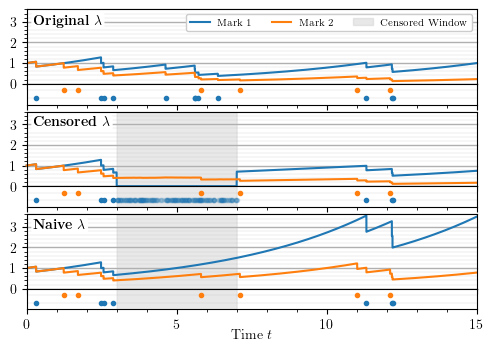

In [180]:
int_height, event_height, gap_height = 2.5, 0.7, 0.25 #3, 1, 0.3
fig, axs = plt.subplots(8, 1, figsize=(4.5, 3), sharey=False, sharex=True, constrained_layout=True, gridspec_kw={"height_ratios":[int_height, event_height, gap_height, int_height, event_height, gap_height, int_height, event_height]})
intensity_axs, event_axs, gap_axs = axs[::3], axs[1::3], axs[2::3]
orig_ax, naive_ax, cen_ax = intensity_axs
naive_ax, cen_ax = cen_ax, naive_ax
oe_ax, ne_ax, ce_ax = event_axs
ne_ax, ce_ax = ce_ax, ne_ax
altered_axs = axs[[3, 4, 6, 7]]
for i in range(2):
    orig_ax.plot(x, orig_intensity["all_mark_intensities"][0,:,i], color=colors[i], label="Mark {}".format(i+1))
    naive_ax.plot(x, naive_intensity["all_mark_intensities"][0,:,i], color=colors[i])
    cen_ax.plot(x, censored_intensity["intensity"][:,i], color=colors[i], clip_on=False)

    oe_ax.plot(times.squeeze(0)[marks.squeeze(0)==i], times.squeeze(0)[marks.squeeze(0)==i]*0+i, '.', color=colors[i])
    ne_ax.plot(c_times.squeeze(0)[c_marks.squeeze(0)==i], c_times.squeeze(0)[c_marks.squeeze(0)==i]*0+i, '.', color=colors[i])
    ce_ax.plot(c_times.squeeze(0)[c_marks.squeeze(0)==i], c_times.squeeze(0)[c_marks.squeeze(0)==i]*0+i, '.', color=colors[i])
    ce_ax.plot(new_times[new_marks==i], new_times[new_marks==i]*0+i, '.', alpha=0.1, color=colors[i])


for ax in intensity_axs:
    ax.set_xlim((0, T))
    ax.set_ylim((0, 3.6))
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.yaxis.set_minor_locator(MultipleLocator(0.2))
    ax.grid(True, which='major', axis='y', linewidth=1, linestyle='-', clip_on=False)
    ax.grid(True, which='minor', axis='y', linewidth=0.3, alpha=0.5, linestyle='-', clip_on=False)
for ax in event_axs:
    ax.set_xlim((0, T))
    ax.set_ylim((-0.9, 1.9))
    ax.yaxis.set_major_locator(MultipleLocator(1))
    ax.tick_params(axis='y', which='both', left=False, labelleft=False)
    ax.grid(True, which='major', axis='y', linewidth=0.3, alpha=0.5, linestyle='-', clip_on=False)
for ax in altered_axs:
    ax.fill_between(x[(x >= 3.) & (x <= 7.)], 0, 1, color='lightgray', alpha=0.5, transform=ax.get_xaxis_transform(), label="Censored Window")
orig_ax.fill_between(x[(x > T)], 0, 1, color='lightgray', alpha=0.5, transform=orig_ax.get_xaxis_transform(), label="Censored Window")  # Will not plot, is being used for legend

orig_ax.legend(loc="upper right", prop={'size': 7}, ncol=3, framealpha=1.0)

title_pos = (0.015, 0.8)
title_fs = 10
title_bbox = dict(boxstyle="round,pad=0.1", fc="white", ec="white")
orig_ax.annotate(r"\textbf{Original} $\mathbf{\lambda}$", bbox=title_bbox, xy=title_pos, fontsize=title_fs, ha='left', xycoords='axes fraction')
naive_ax.annotate(r"\textbf{Naive} $\mathbf{\lambda}$", bbox=title_bbox, xy=title_pos, fontsize=title_fs, ha='left', xycoords='axes fraction')
cen_ax.annotate(r"\textbf{Censored} $\mathbf{\lambda}$", bbox=title_bbox, xy=title_pos, fontsize=title_fs, ha='left', xycoords='axes fraction')

ne_ax.set_xlabel(r"Time $t$", fontsize=10, labelpad=-2)

for ax in gap_axs:
    ax.set_visible(False)
fig.subplots_adjust(
    left   = 0.0,  # the left side of the subplots of the figure
    right  = 1.0,    # the right side of the subplots of the figure
    bottom = 0.0,   # the bottom of the subplots of the figure
    top    = 1.0,      # the top of the subplots of the figure
    wspace = 0.0,   # the amount of width reserved for blank space between subplots
    hspace = 0.0,   # the amount of height reserved for white space between subplots
)
dir_prefix = "/home/alexjb/source/point_process_queries"
dest_path = dir_prefix + "/data/plots/final_plots/example_intensities.pdf"
fig.savefig(dest_path, bbox_inches="tight", transparent=True)

In [103]:
x[(x >= 3.) & (x <= 7.)]

tensor([3.0003, 3.0018, 3.0033,  ..., 6.9967, 6.9982, 6.9997])

In [141]:
axs

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)